# Paris Airbnb Data

In [1]:
import pathlib
import pickle
import pandas as pd
import seaborn as sns

import utils

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
processed_file_path = DATA_DIR / 'processed' / 'data_paris.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)

In [3]:
data.head()

,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Restraunt Index,LogPrice,Price_per_GDP,LogPrice_per_GDP
22462,Paris,296.159940,Weekday,Private room,False,True,2.0,True,0.0,0.0,10,97,1.0,0.699821,0.193709,518.478947,1218.662228,2.471526,0.006783,-2.168547
22463,Paris,288.237487,Weekday,Private room,False,True,2.0,True,0.0,0.0,10,97,1.0,2.100005,0.107221,873.216962,1000.543327,2.459750,0.006602,-2.180323
22464,Paris,211.343089,Weekday,Private room,False,True,2.0,False,0.0,0.0,10,94,1.0,3.302325,0.234724,444.556077,902.854467,2.324988,0.004841,-2.315086
22465,Paris,298.956100,Weekday,Entire home/apt,False,False,2.0,False,0.0,1.0,9,91,1.0,0.547567,0.195997,542.142014,1199.184166,2.475607,0.006848,-2.164466
22466,Paris,247.926181,Weekday,Entire home/apt,False,False,4.0,False,0.0,0.0,7,82,1.0,1.197921,0.103573,406.928958,1070.775497,2.394322,0.005679,-2.245751


##### Treating Price Outliers 

<Axes: xlabel='LogPrice', ylabel='Density'>

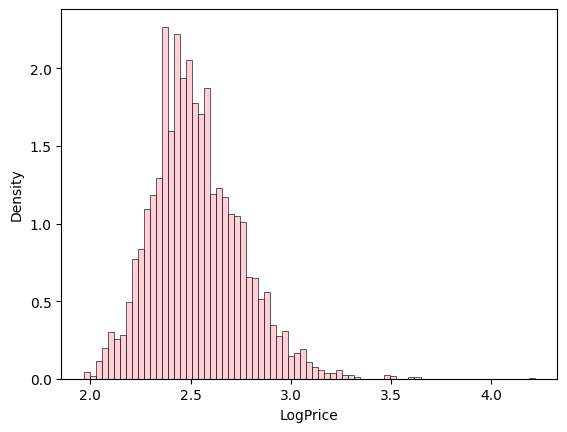

In [4]:
sns.histplot(data['LogPrice'], color = 'pink', stat="density")

In [5]:
q1=data['LogPrice'].quantile(.25)
q2=data['LogPrice'].quantile(.50)
q3=data['LogPrice'].quantile(.75)
iqr=q3-q1
print('first quartile is %.1f'%q1)
print('second quartile is %.1f'%q2)
print('third quartile is %.1f'%q3)
print('interquartile range is %.1f'%iqr)

limit_low=q1-iqr*1.999
limit_high=q3+iqr*1.999
print('lower limit is %.1f'%limit_low)
print('upper limit is %.1f'%limit_high)

first quartile is 2.4
second quartile is 2.5
third quartile is 2.7
interquartile range is 0.3
lower limit is 1.8
upper limit is 3.2


In [6]:
data = data[data['LogPrice'] < limit_high].copy()

<Axes: xlabel='LogPrice', ylabel='Count'>

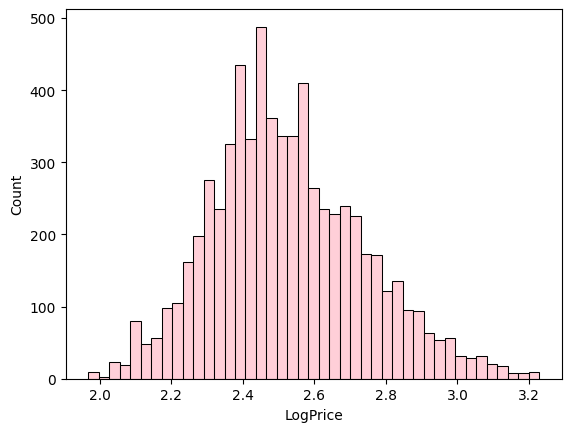

In [7]:
sns.histplot(data['LogPrice'], color = 'pink')

Limpando variaveis categoricas que não serão usadas nesta análise

In [8]:
cat_variables = categorical_variables
cat_variables.remove('City')

             count unique              top  freq
Day           6654      2          Weekend  3541
Room Type     6654      3  Entire home/apt  5034
Shared Room   6654      2            False  6560
Private Room  6654      2            False  5128
Superhost     6654      2            False  5718


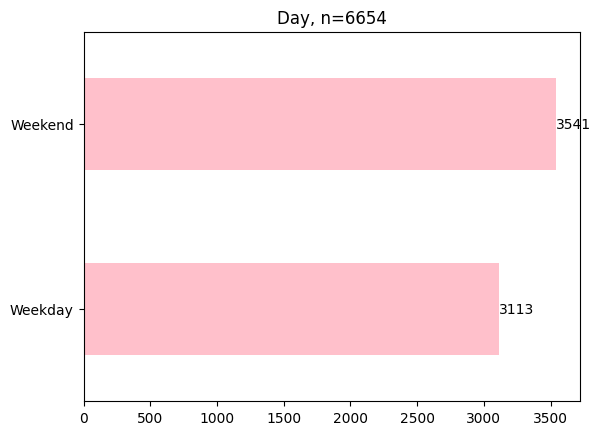

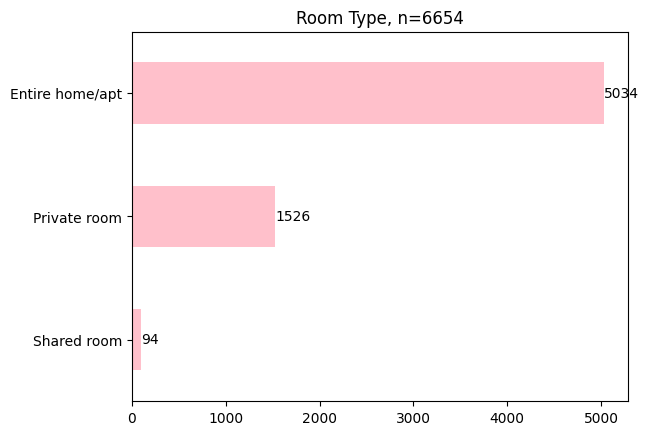

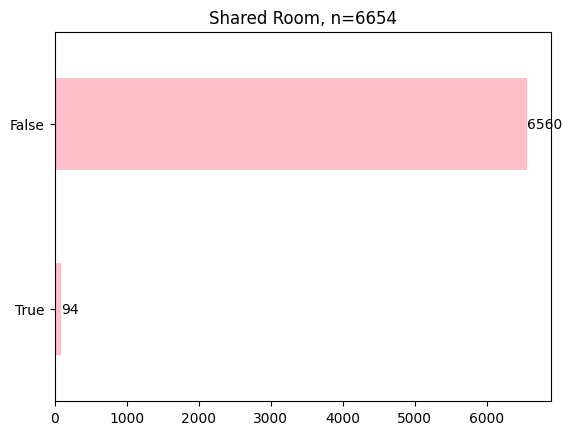

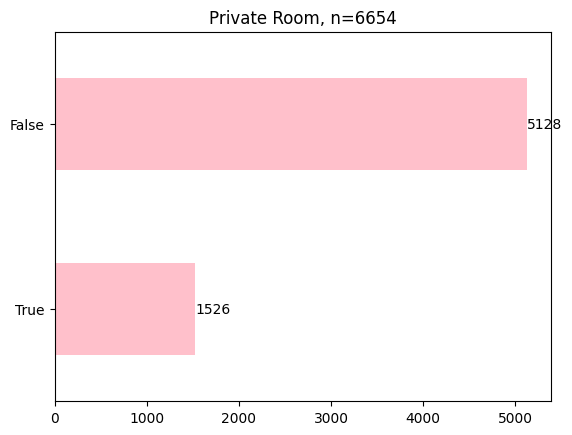

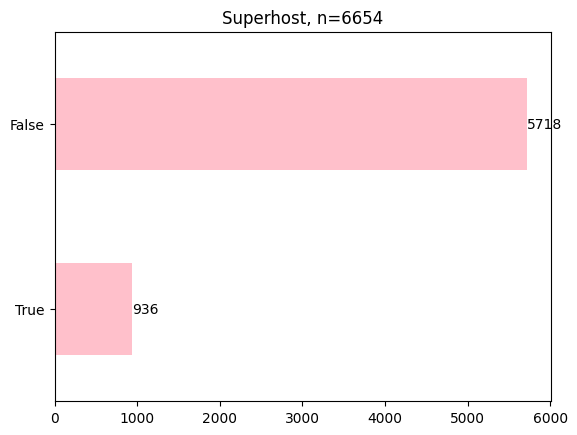

In [9]:
utils.plot_categoricals(data, cat_variables)

OBS: Quase não temos dados para shared rooms

DECISÃO: Remover airbnb que são do tipo shared rooms

In [10]:
data = data[data['Room Type'] != 'Shared room'].copy()
data.drop(columns = ['Shared Room'], inplace = True)

                  count      mean       std  min  25%  50%  75%  max
Person Capacity  6560.0  2.932470  1.193383  2.0  2.0  2.0  4.0  6.0
Multiple Rooms   6560.0  0.220427  0.414566  0.0  0.0  0.0  0.0  1.0
Business         6560.0  0.239482  0.426800  0.0  0.0  0.0  0.0  1.0
Bedrooms         6560.0  0.964482  0.637632  0.0  1.0  1.0  1.0  5.0


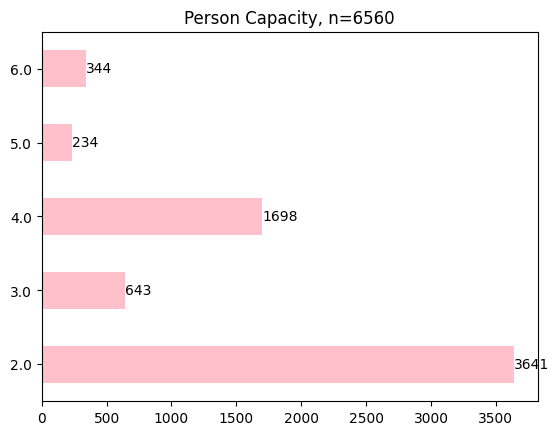

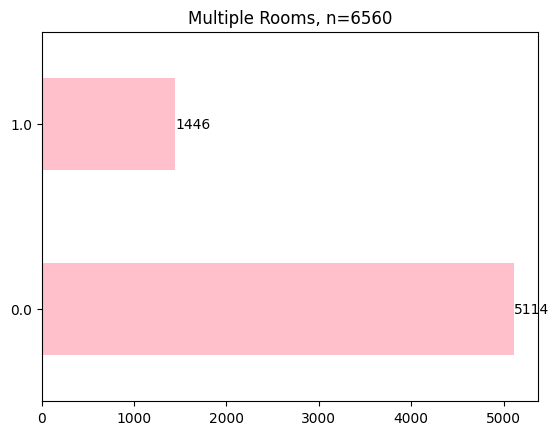

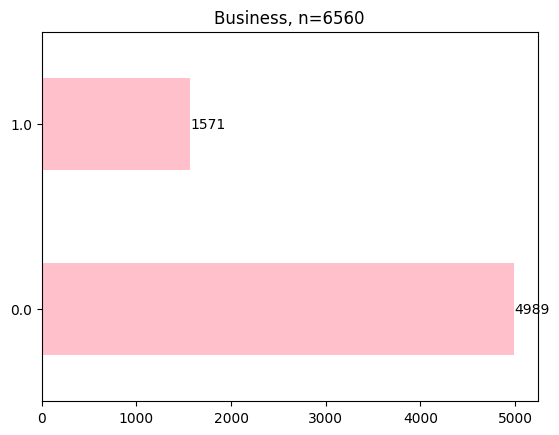

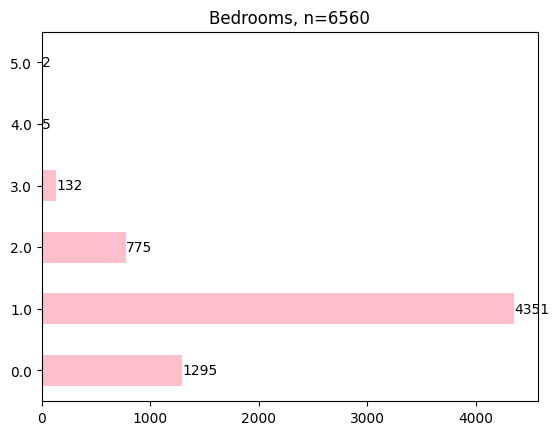

In [11]:
utils.plot_discretes(data, discrete_variables, sorted=False)

Limpando variaveis continuas que não serão usadas nesta análise

In [12]:
cat_continuous = continuous_variables
cat_continuous.remove('Normalised Attraction Index')
cat_continuous.remove('Normalised Restraunt Index')

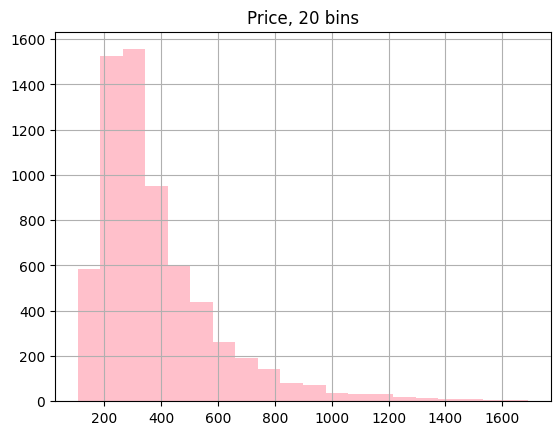

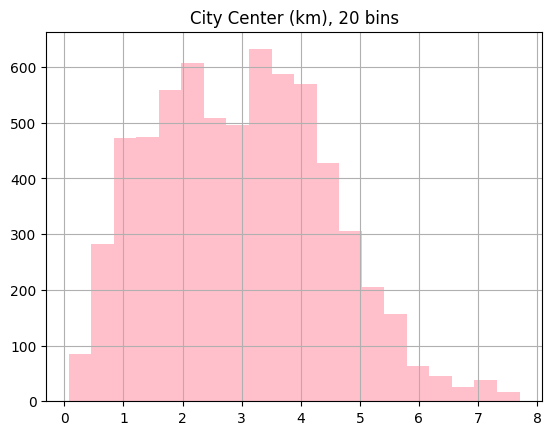

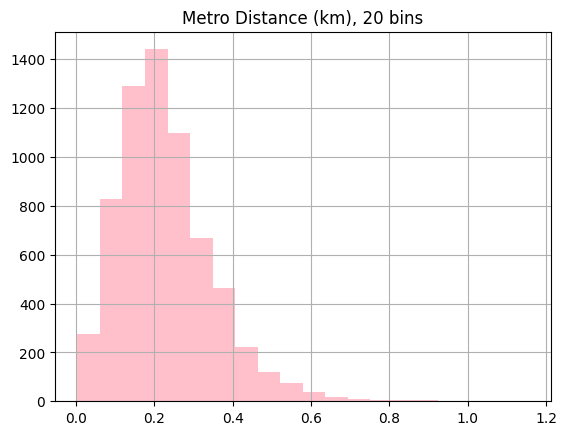

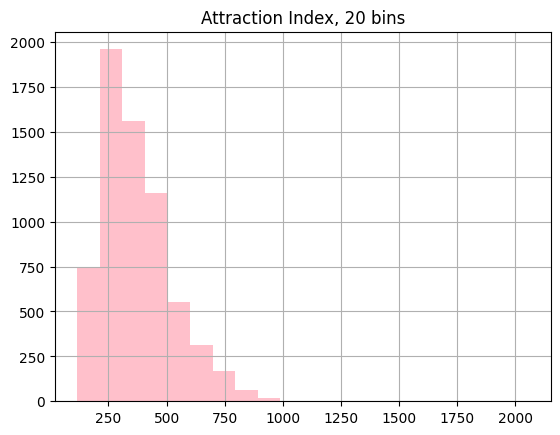

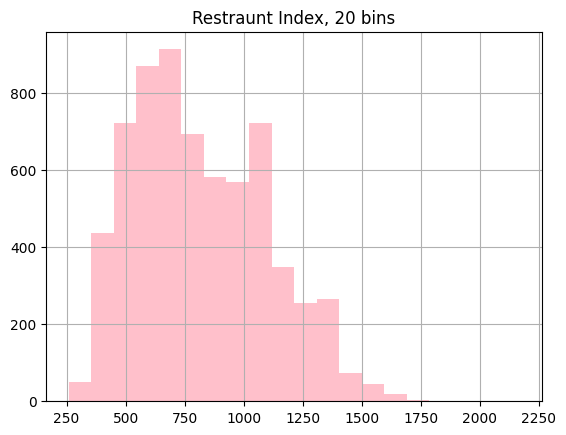

In [13]:
utils.plot_continuous(data, cat_continuous)

Vamos analisar dois tipos de airbnb separadamente, entire home/apt e private room, em buscada de identificar caracteristicas que influenciam o preço para cada um desses tipos. 

## Paris Entire home/apt

In [14]:
data_entire_homeapt = data.loc[data['Room Type'] == 'Entire home/apt'].copy()

<Axes: >

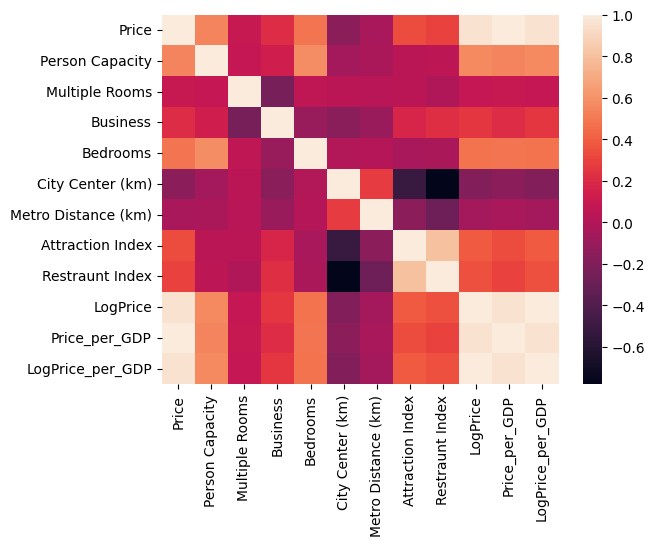

In [15]:
corr = data_entire_homeapt.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [16]:
corr['LogPrice'].sort_values()

City Center (km)      -0.194673
Metro Distance (km)   -0.055721
Multiple Rooms         0.077640
Business               0.251045
Restraunt Index        0.352989
Attraction Index       0.381896
Bedrooms               0.476832
Person Capacity        0.563624
Price                  0.952246
Price_per_GDP          0.952246
LogPrice_per_GDP       1.000000
LogPrice               1.000000
Name: LogPrice, dtype: float64

#### Modelo - Lasso

In [17]:
data_entire_homeapt = pd.get_dummies(data_entire_homeapt, columns = ['City','Day','Private Room','Superhost'], drop_first = True)

In [18]:
features = data_entire_homeapt.drop(columns=['Price', 'LogPrice', 'Price_per_GDP', 'LogPrice_per_GDP', 'City_Athens', 'City_Barcelona','City_Berlin','City_Budapest','City_Lisbon','City_Paris','City_Rome','City_Vienna', 'Room Type']).copy()
target = data_entire_homeapt['LogPrice_per_GDP'].copy()

In [19]:
X = features
Y = target

In [20]:
# Dicionário vazio para armazenar os coeficientes
coeficientes_dict = {}

# Itere de 1 a 1001
for random_state in range(1, 1002):
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

    # Divida os dados de treinamento em conjuntos de treinamento e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

     # Crie uma instância do modelo de Lasso
    modeloAmsterdam_Lasso01 = Lasso(alpha=0.05)

    # Treine o modelo
    modeloAmsterdam_Lasso01.fit(X_train, y_train)

    # Obtenha os coeficientes
    coeficientes = dict(zip(modeloAmsterdam_Lasso01.feature_names_in_, modeloAmsterdam_Lasso01.coef_))
    
    # Atualize o dicionário de coeficientes
    for feature, coeficiente in coeficientes.items():
        if feature not in coeficientes_dict:
            coeficientes_dict[feature] = []
        coeficientes_dict[feature].append(coeficiente)

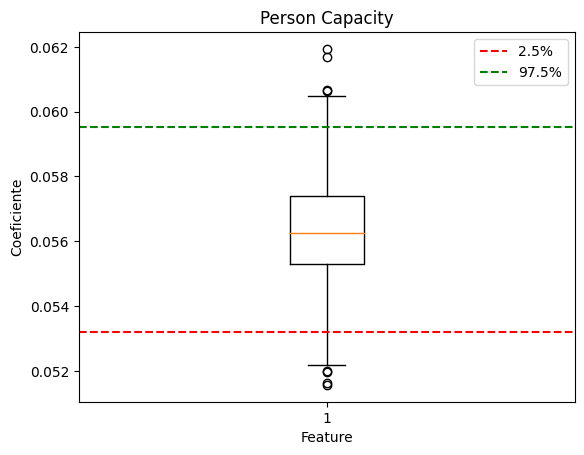

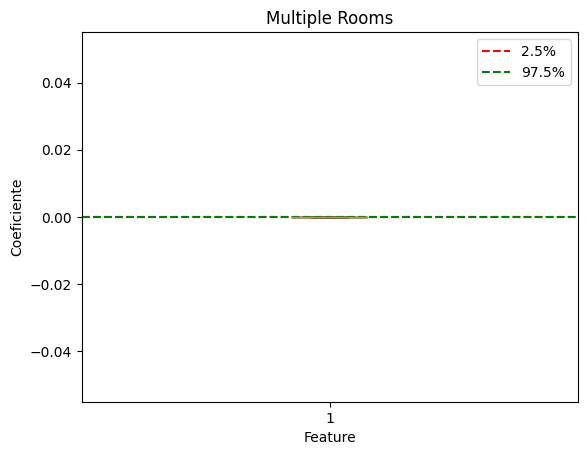

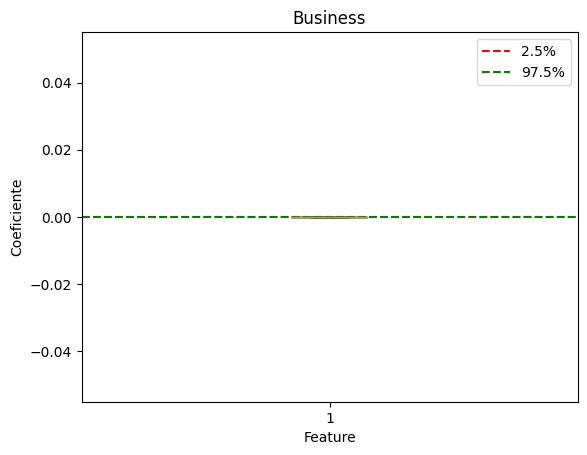

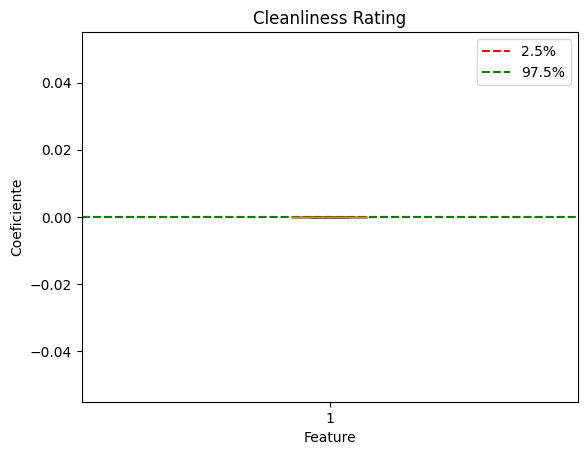

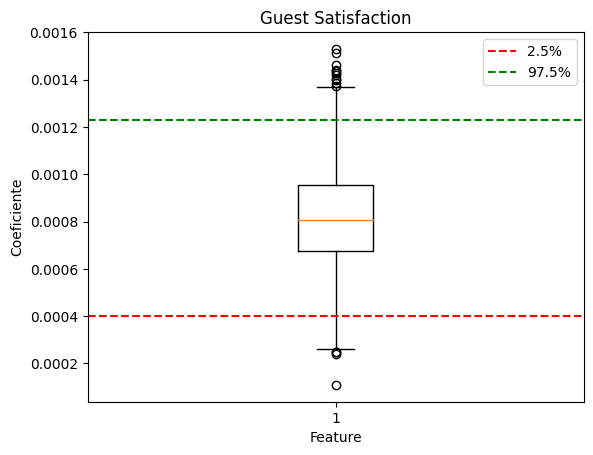

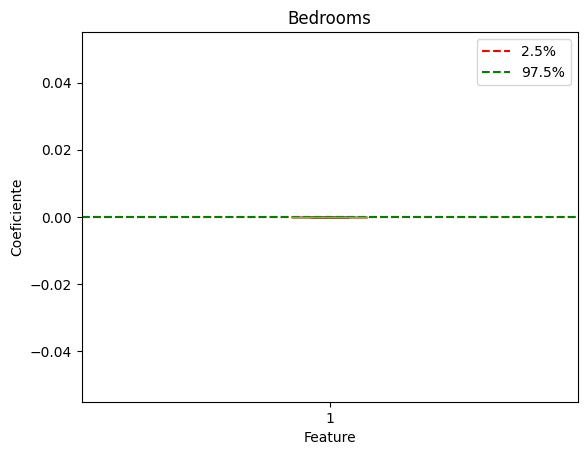

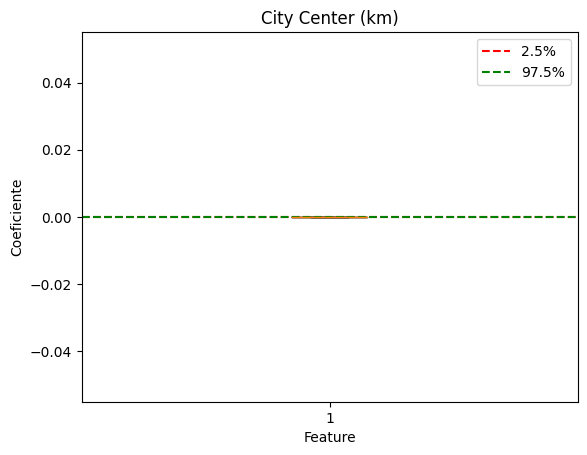

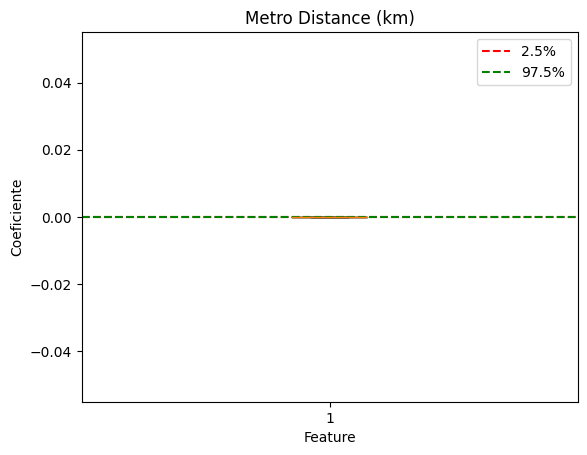

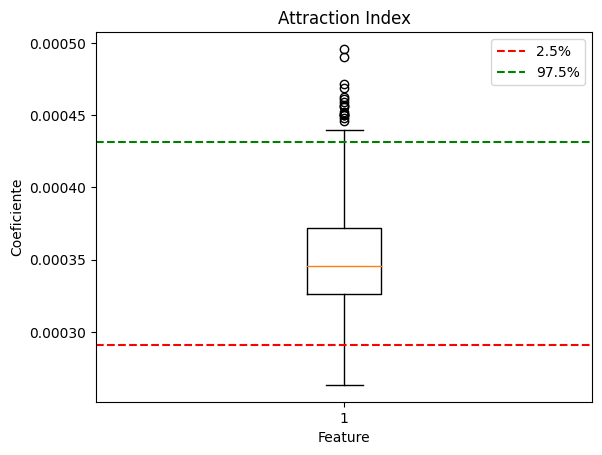

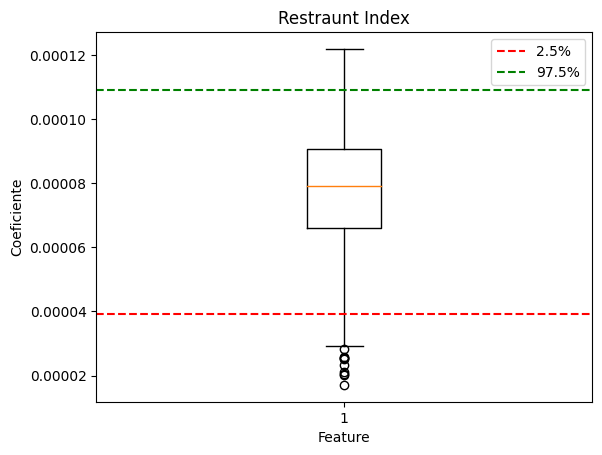

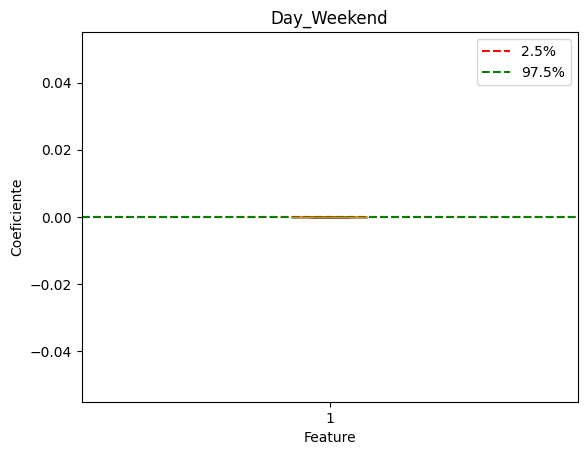

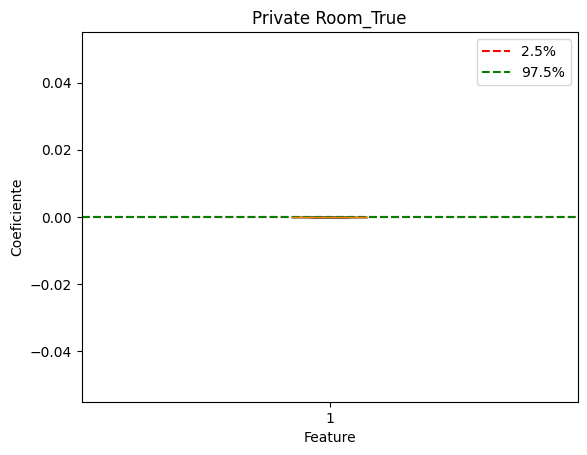

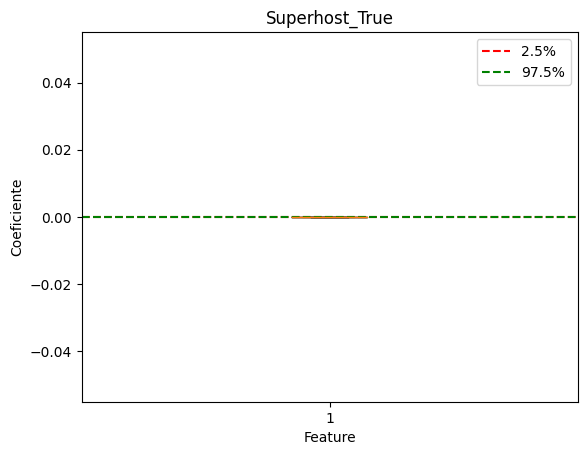

In [21]:
utils.plot_coefModeloLasso(coeficientes_dict)

## Paris Private room

In [22]:
data_private_room = data.loc[data['Room Type'] == 'Private room'].copy()

<Axes: >

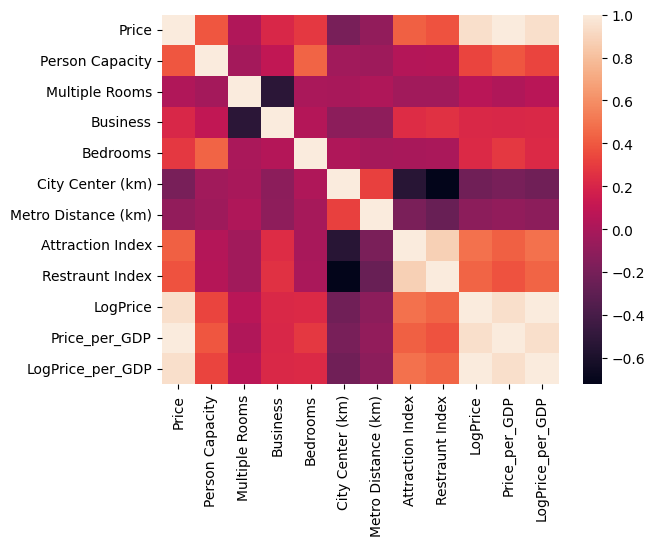

In [23]:
corr = data_private_room.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [24]:
corr['LogPrice'].sort_values()

City Center (km)      -0.225542
Metro Distance (km)   -0.111121
Multiple Rooms         0.063966
Business               0.218270
Bedrooms               0.220360
Person Capacity        0.329696
Restraunt Index        0.438186
Attraction Index       0.488171
Price_per_GDP          0.939981
Price                  0.939981
LogPrice_per_GDP       1.000000
LogPrice               1.000000
Name: LogPrice, dtype: float64

In [25]:
data_private_room = pd.get_dummies(data_private_room, columns = ['City','Day','Private Room','Superhost'], drop_first = True)

In [26]:
features = data_private_room.drop(columns=['Price', 'LogPrice', 'Price_per_GDP', 'LogPrice_per_GDP', 'City_Athens', 'City_Barcelona','City_Berlin','City_Budapest','City_Lisbon','City_Paris','City_Rome','City_Vienna', 'Room Type']).copy()
target = data_private_room['LogPrice_per_GDP'].copy()

In [27]:
X = features
Y = target

In [28]:
# Dicionário vazio para armazenar os coeficientes
coeficientes_dict = {}

# Itere de 1 a 1001
for random_state in range(1, 1002):
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

    # Divida os dados de treinamento em conjuntos de treinamento e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

     # Crie uma instância do modelo de Lasso
    modeloAmsterdam_Lasso01 = Lasso(alpha=0.05)

    # Treine o modelo
    modeloAmsterdam_Lasso01.fit(X_train, y_train)

    # Obtenha os coeficientes
    coeficientes = dict(zip(modeloAmsterdam_Lasso01.feature_names_in_, modeloAmsterdam_Lasso01.coef_))
    
    # Atualize o dicionário de coeficientes
    for feature, coeficiente in coeficientes.items():
        if feature not in coeficientes_dict:
            coeficientes_dict[feature] = []
        coeficientes_dict[feature].append(coeficiente)

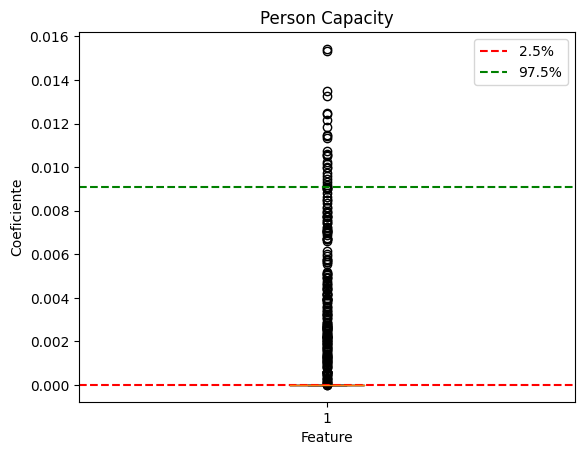

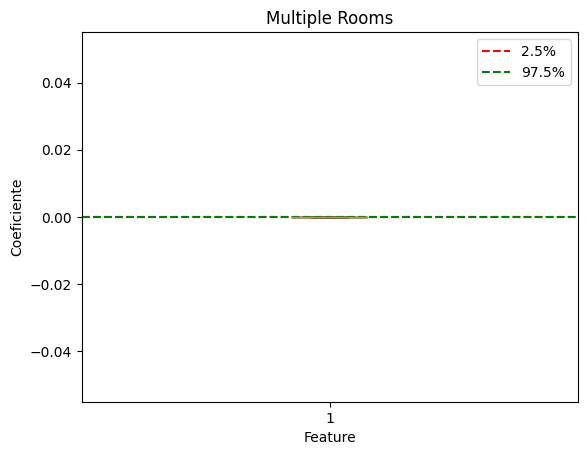

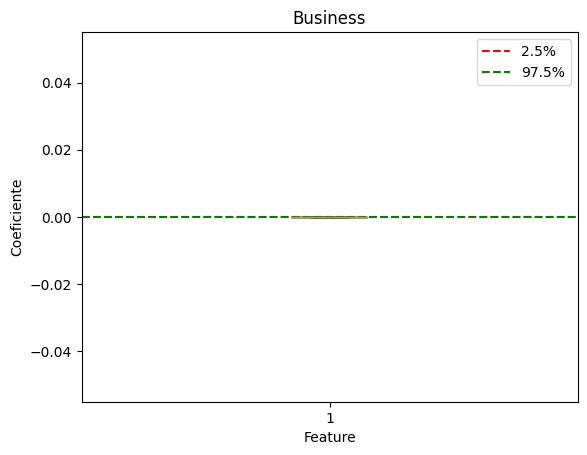

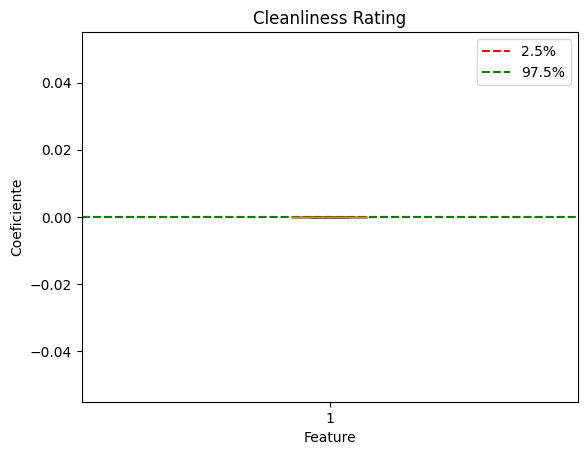

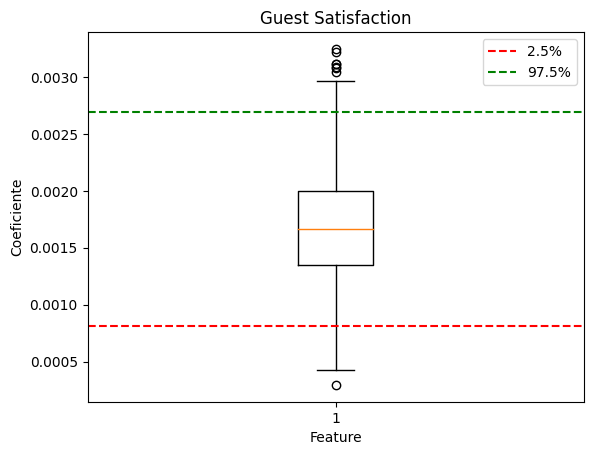

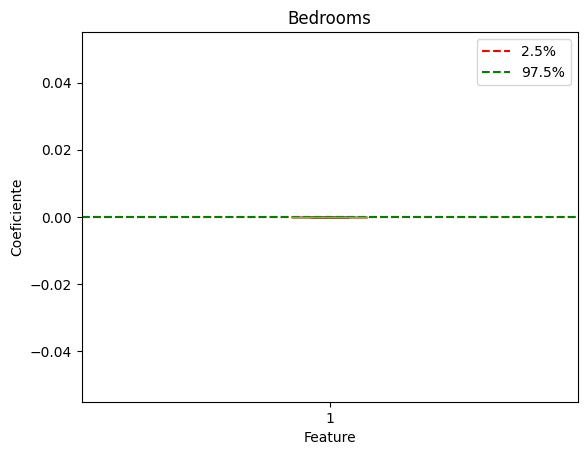

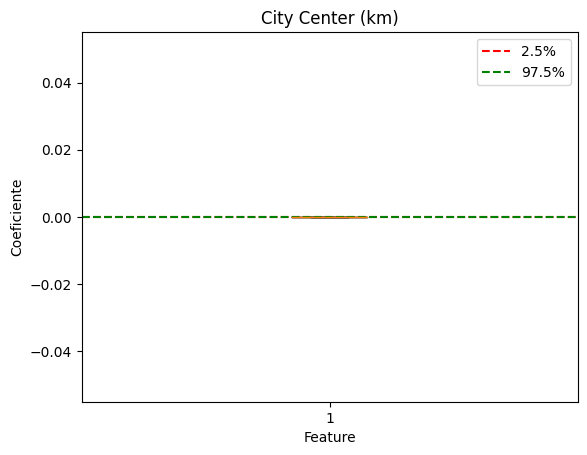

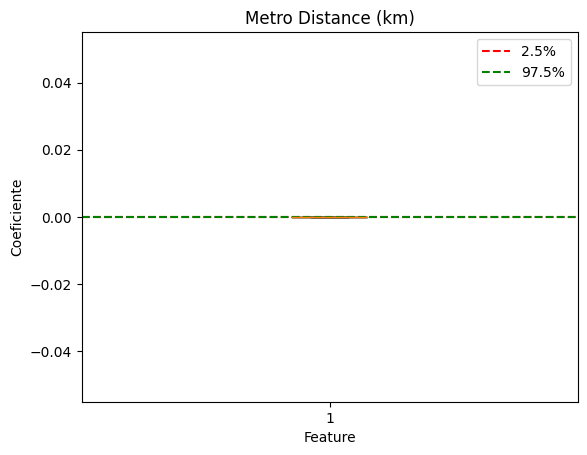

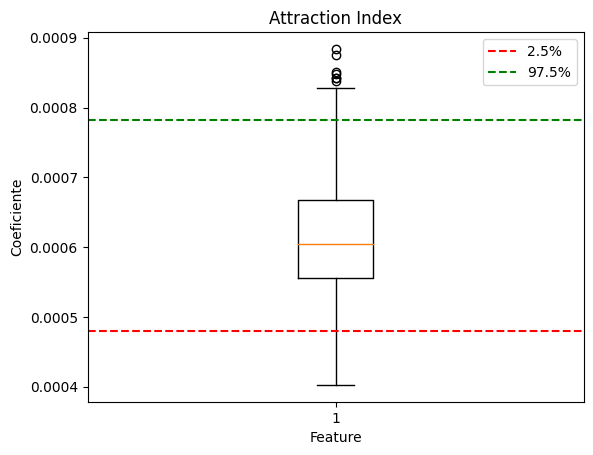

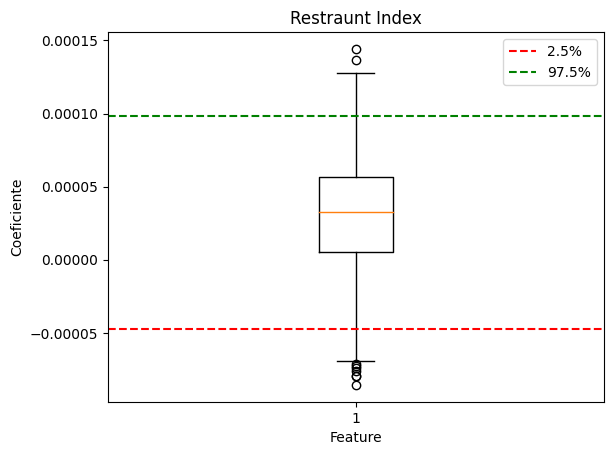

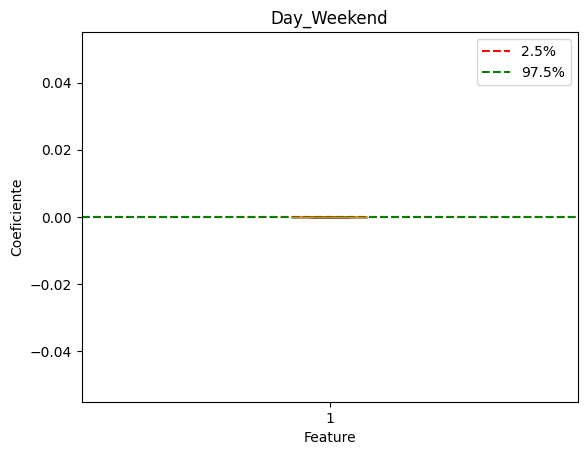

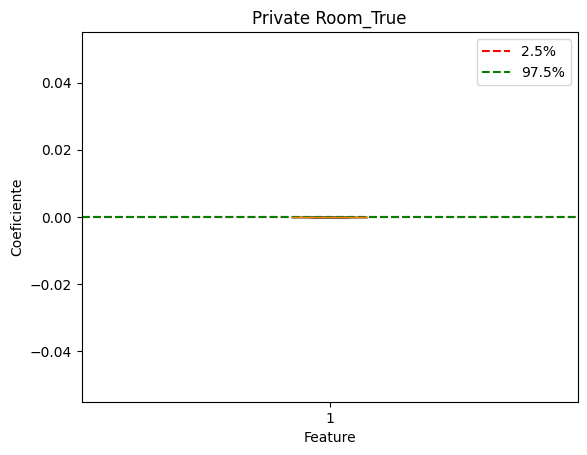

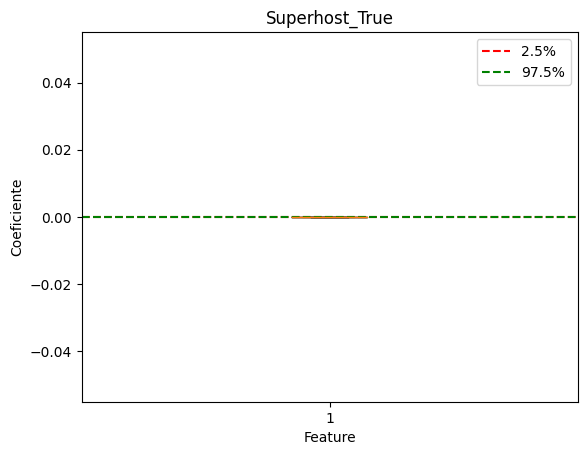

In [29]:
utils.plot_coefModeloLasso(coeficientes_dict)